## Домашнее задание №6. Neural Machine Translation
Сдача задания производится по адресу `bdt-mf-ml-nlp-2020-q4@bigdatateam.org`

В теме письма указать: "HW6:NMT. ФИО"

Если какие-то библиотеки недоступны, можно установить их в используемое окружение (environment), например `my_env`, используя пакетный менеджер `pip`: 

```
conda activate my_env
pip install pandas 
```

Пример настройки окружения и `requirements.txt` доступны в репозитории: https://github.com/big-data-team/nlp-course

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip install nltk
! pip install torchtext==0.5

     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 1.2MB 18.8MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


___

Данное задание состоит из единственной части. Вам предстоит построить систему машинного перевода с русского на английский язык, т.е. для языковой пары RU-EN.

Базовое решение на основе RNN уже реализовано.

__Цель данного задания__: проанализирвать различные подходы к построению более качественной системы машинного перевода. В данном задании у вас достаточно широкий простор для экспериментов. 

Вы можете воспользоваться одним (или несколькими) из следующих подходов:
* Использовать предобученные эмбеддинги для слов (для русского языка они доступны, например, [здесь](http://docs.deeppavlov.ai/en/master/features/pretrained_vectors.html))
* Воспользоваться сверточной сетью в качестве энкодера
* Добавить механизм внимания (attention) для используемой архитектуры
* Предобучить языковые модели для исходного и целевого языков и затем перейти к задаче перевода
* Воспользоваться архитектурой Transformer
* Использовать предобученный BERT в качестве энкодера
* Или описать и использовать свою собственную идею.

__Основное ограничение__: использование того или иного подхода должно быть обосновано, а результаты должны быть тщательно проанализированы.

Более подробное описание задач доступно после baseline-решения.

___

##### Комментарий:
Рекомендуем перенести класс(ы) используемой архитектуры/слоев в файл `my_network.py`, а в ноутбуке оставить непосредственно графики и эксперименты.

Для технических функций можно воспользоваться `utils.py`.

В данных файлах уже доступна базовая архитектура и некоторые технические функции.

_Если при загрузке обнолвенной версии файла возникнут проблемы, можно воспользоваться модулем `imp`. В крайнем случае можно перенести код модели и технических функций в ноутбук (но при сдаче задания лучше вынести их в соответствующие файлы и проверить, что необходимые классы и функции корректно импортируются)._

__Если вы выполняете задание на Colab, не забывайте сохранять локальные копии как ноутбука, так и сопутствующих файлов (или используйте привязку к Google Drive). Несохраненные файлы могут быть утеряны при долгом простое сессии в Colab.__

___

Задаче машинного перевода будет решаться на примере данных, доступных ниже. Они представляют собой параллельные корпуса текстов на английском и русском языках.

*Выражаем свою благодарность командам tilda и deephack, а также команде ШАД (ссылающейся на tilda и deephack в свою очередь) за предоставленные данные.*

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import random
import math
import time

In [3]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

print("Downloading from github. Loading special files as well")
!wget https://raw.githubusercontent.com/big-data-team/nlp-course/main/materials/HW06_NMT/data.txt -nc
path_do_data = './data.txt'

--2021-02-12 22:49:32--  https://raw.githubusercontent.com/big-data-team/nlp-course/main/materials/HW06_NMT/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  57.5MB/s    in 0.2s    

2021-02-12 22:49:33 (57.5 MB/s) - ‘data.txt’ saved [12905334/12905334]



Также загрузим файлы `utils.py` и `my_network.py`. __Не забудьте их сохранить, если вносите в них изменения!__

In [4]:
print("Downloading `utils.py` file from github.")
!wget https://raw.githubusercontent.com/big-data-team/nlp-course/main/materials/HW06_NMT/utils.py -nc


print("Downloading `my_network.py` file from github.")
!wget https://raw.githubusercontent.com/big-data-team/nlp-course/main/materials/HW06_NMT/my_network.py -nc

--2021-02-12 22:49:33--  https://raw.githubusercontent.com/big-data-team/nlp-course/main/materials/HW06_NMT/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     932  --.-KB/s    in 0s      

2021-02-12 22:49:34 (68.5 MB/s) - ‘utils.py’ saved [932/932]

--2021-02-12 22:49:34--  https://raw.githubusercontent.com/big-data-team/nlp-course/main/materials/HW06_NMT/my_network.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5997 (5.9K) [text/

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

import my_network
import utils

### Предобработка данных.
Базовая предобработка данных сделана за вас. Для токенизации используется простой `WordPunctTokenizer` из `nltk`. Вы можете воспользоваться более сложными токенизаторами, реализовав собственные функции для токенизации.

In [8]:
DEFAULT_TOKENIZER = WordPunctTokenizer()

def tokenize(x, tokenizer=DEFAULT_TOKENIZER):
    return tokenizer.tokenize(x.lower())

Создадим `Field` для исходного и целевого языков. Все данные приводятся к нижнему регистру. 

In [9]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Для загрузки собственного датасета в подходящем формате воспользуемся `torchtext.data.TabularDataset`. В качестве разделителя используется табуляция, поэтому указанный формат: `tsv`.

In [10]:
dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

Разобьем данные на обучающую, валидационную и тестовую выборки.

*Комментарий: обращаем ваше внимание, random seed не зафиксирован. Для получения воспроизводимых результатов запусков вы можете его зафиксировать*.

In [11]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [12]:
print(f"Размер обучающей выборки: {len(train_data.examples)}")
print(f"Размер валидационной выборки: {len(valid_data.examples)}")
print(f"Размер тестовой выборки: {len(test_data.examples)}")

Размер обучающей выборки: 40000
Размер валидационной выборки: 2500
Размер тестовой выборки: 7500


Построим словарь, используя токены, которые встречались не менее трех раз.

In [13]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [14]:
print(f"Количество уникальных токенов в русском словаре: {len(SRC.vocab)}")
print(f"Количество уникальных токенов в английском словаре: {len(TRG.vocab)}")

Количество уникальных токенов в русском словаре: 9244
Количество уникальных токенов в английском словаре: 6693


Несколько слов из русского словаря:

In [15]:
SRC.vocab.itos[::1000]

['<unk>',
 'palace',
 'четырехзвездочный',
 'кухонной',
 'der',
 'центральное',
 'isola',
 'уолта',
 'доступно',
 'тенистой']

И из английского словаря:

In [16]:
TRG.vocab.itos[::1000]

['<unk>', 'breakfasts', 'fresco', 'done', 'midlands', 'southeast', 'manta']

Пример из обучающей выборки:

In [17]:
print(vars(train_data.examples[9]))

{'trg': ['the', 'property', 'offers', 'free', 'parking', '.'], 'src': ['гости', 'могут', 'воспользоваться', 'бесплатной', 'парковкой', '.']}


Как видим, в данных в том числе присутствуют имена собственные и слова из других языков.

Построим диаграммы распределений длин предложений в данных (в символах):

Распределение длин текстов в обучающих данных


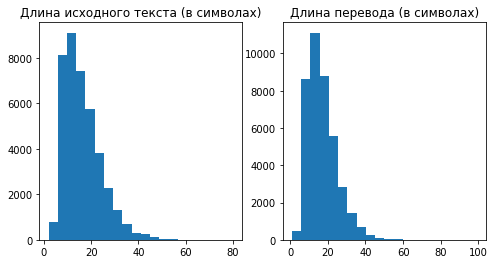

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Распределение длин текстов в обучающих данных')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("Длина исходного текста (в символах)")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("Длина перевода (в символах)")
plt.hist(list(trg_length), bins=20);

Распределение длин текстов в тестовых данных


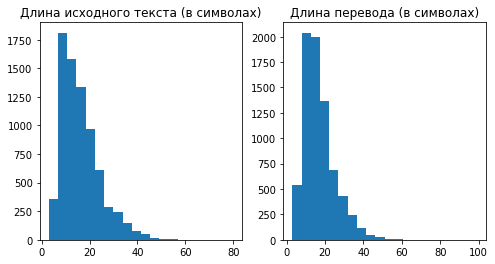

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Распределение длин текстов в тестовых данных')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("Длина исходного текста (в символах)")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("Длина перевода (в символах)")
plt.hist(list(trg_length), bins=20);

### Базовое решение
Простое решение на основе RNN представлено ниже.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
print(device)

cuda


Параметр `sort_key` указывает, по какому принципу упорядочивать последовательности. В данном случае учитывается длина предложения на русском языке.

In [20]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

Проверим, что данные корректно прочитаны.

In [21]:
x = next(iter(train_iterator))

print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 38x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 43x128 (GPU 0)]
torch.Size([43, 128]) torch.Size([38, 128])


Обращаем ваше внимание на размерность батча: `(seq_length, batch_size)`

Ниже доступно базовое решение.

In [ ]:
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

Явно проинициализируем веса равномерным распределением.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9267, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6715, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6715, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Оценим количество параметров в модели.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'В модели {count_parameters(model):,} параметров')

В модели 14,892,603 параметров


Не забывайте про указание `<pad>`-токена в функции потерь. 

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

Базовый код для обучения модели доступен ниже. Обращаем ваше внимание, в данном случае Tensorboard не используется. Рекомендуем воспользоваться наработками с семинара и переключиться на него ;)

In [22]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Функция ниже поможет преобразовать время в минуты и секунды.

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Сам процесс обучения доступен ниже.

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

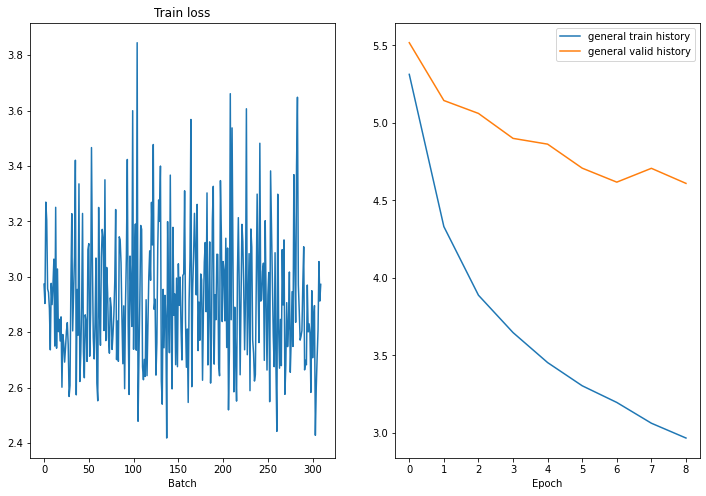

Epoch: 10 | Time: 1m 9s
	Train Loss: 2.920 | Train PPL:  18.536
	 Val. Loss: 4.602 |  Val. PPL:  99.673


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Оценка качества работы модели__:

In [ ]:
# if updated code is not loading, try using the `imp` module
# import utils
# import imp
# imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the property offers free parking .
Generated: free private parking is available on site .

Original: free wifi access is available here . santa lucia hill is a 10 - minute car ride away .
Generated: the rooms have free wi - fi .



В библиотеке `nltk` также доступна функция `corpus_bleu` для оценки BLEU на целом корпусе. Ее короткое описание доступно ниже. Она уже импортирована в начале ноутбука, строка с импортом приведена для справки.

In [ ]:
# from nltk.translate.bleu_score import corpus_bleu


#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].cpu().numpy().T])

59it [00:02, 22.19it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.032097690264637

___


__Ваша задача__: Используйте как минимум четыре различных подхода (помимо уже доступного baseline-решения). Сравните полученные результаты между собой используя подходящие критерии качества (BLEU/Perplexity/...). Оцените степень переобучения в каждом из экспериментов. Оцените скорость обучения и применения (inference'а) каждой из моделей в пересчете на один батч размером 32.

Сделайте короткое описание экспериментов и проиллюстрируйте их с помощью графиков.

Эксперименты должны удовлетворять следующим ограничениям:

1. Хотя бы в одном эксперименте используются позиционные эмбеддинги с Transformer Encoder или CNN в качестве энкодера. Производится сравнение качества перевода одной и той же архитектурой с и без позиционных эмбеддингов.

**Внимание, при использовании предобученной модели в качестве энкодера исключать позиционные эмбеддинги (если они уже есть) не стоит. Модель уже была обучена работать информацией определенной природы, и изменение природы данных приведет к значительному снижению качества.** В данном эксперименте лучше использовать простую CNN/Transformer архитектуру, обученную с нуля.

2. Хотя бы в одном эксперименте используется Transformer Decoder в качестве декодера (или модель сходной архитектуры, например, GPT).
3. Каждый эксперимент проиллюстрирован графиками, присутствует описание идеи, которая послужила поводом для его проведения.
4. Для каждого эксперимента произведена оценка времени работы в режиме inference усредненная для батча размера 32 и батча размера 1.

Качество базового решения можно значительно увеличить. Попробуйте достичь как минимум BLEU=__24__ на тестовых данных. Отличным результатом можете считать BLEU=__28__ и выше.

___

### Эксперимент №1 (22.5%)
__Гипотеза:__ Тут не было особой гипотезы, просто для сравнения качества было проще использовать ГРУ, так как меньше нужно было париться с хидден слоем, и проще реализовать пол него CNN autoencoder

In [144]:
Encoder = Encoder_GRU
Decoder = Decoder_GRU
Seq2Seq = Seq2Seq_GRU

In [145]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [146]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq_GRU(
  (encoder): Encoder_GRU(
    (embedding): Embedding(9244, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(6693, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6693, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [147]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'В модели {count_parameters(model):,} параметров')

В модели 13,030,693 параметров


In [148]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [149]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

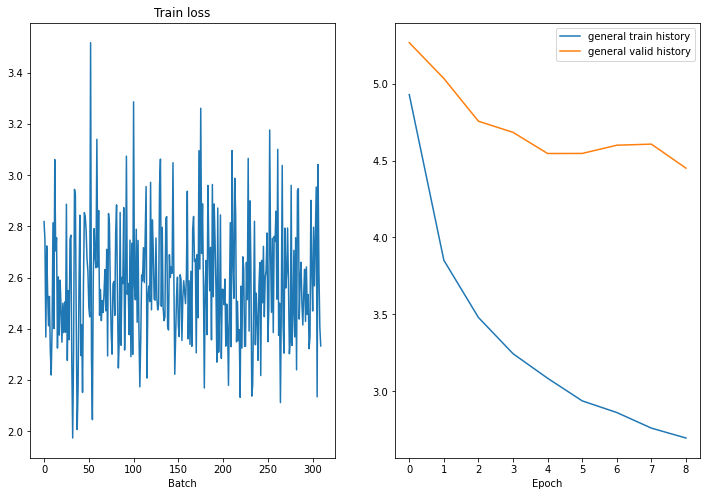

Epoch: 10 | Time: 1m 18s
	Train Loss: 2.576 | Train PPL:  13.142
	 Val. Loss: 4.598 |  Val. PPL:  99.306


In [150]:
for epoch in range(10):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [151]:
# if updated code is not loading, try using the `imp` module
# import utils
# import imp
# imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [152]:
batch = next(iter(test_iterator))

In [153]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: guests can enjoy the on - site restaurant .
Generated: guests can enjoy the on - site restaurant .

Original: guests benefit from terrace .
Generated: terrace .



In [154]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].cpu().numpy().T])

59it [00:03, 16.38it/s]


In [155]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

19.790181224269716

___

### Эксперимент №2 (22.5%)
__Гипотеза:__ Попробовать CNN енкодер, так как тексты большие и можно вынести много информации из биграммов. В CNN использовались окна размерами 2,3,4,5. Плюс, как мне кажется, CNN не так сильно нужны позиционные енкодинги, так как мы все равно берем макс пулинг по слоям. 

In [ ]:
Encoder = Encoder_CNN
Decoder = Decoder_GRU
Seq2Seq = Seq2Seq_GRU

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
NUM_FILTERS = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, HID_DIM, ENC_EMB_DIM, NUM_FILTERS, ENC_DROPOUT, N_LAYERS, 2, ngram_filter_sizes=(2, 3, 4, 5)) #(self, input_dim, out_dim, emb_dim, num_filters, dropout, stride, ngram_filter_sizes=(2, 3, 4, 5))
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq_GRU(
  (encoder): Encoder_CNN(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(9261, 256)
    (conv_1): Conv1d(256, 256, kernel_size=(2,), stride=(2,))
    (conv_2): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (conv_3): Conv1d(256, 256, kernel_size=(4,), stride=(2,))
    (conv_4): Conv1d(256, 256, kernel_size=(5,), stride=(2,))
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(6744, 256)
    (rnn): GRU(256, 512, dropout=0.5)
    (out): Linear(in_features=512, out_features=6744, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'В модели {count_parameters(model):,} параметров')

В модели 10,183,000 параметров


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

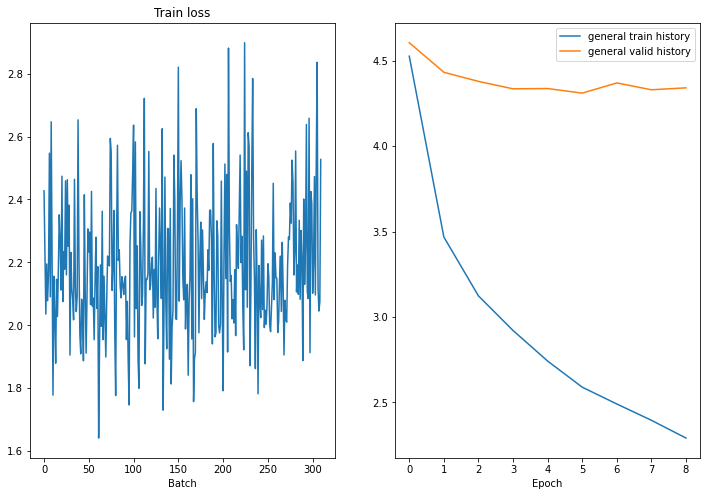

Epoch: 10 | Time: 1m 9s
	Train Loss: 2.187 | Train PPL:   8.909
	 Val. Loss: 4.399 |  Val. PPL:  81.380


In [ ]:
for epoch in range(10):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# if updated code is not loading, try using the `imp` module
# import utils
# import imp
# imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: guests benefit from a terrace .
Generated: guests benefit from terrace .



In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].cpu().numpy().T])

59it [00:03, 18.38it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

23.30969704997825

___

### Эксперимент №3 (22.5%)
__Гипотеза:__ Попробовать Трансформер декодер, потому что это мощная архитектура, которая теоретически может бустануть результаты при переводе. Текстов и их размера по идее должно хватить, чтобы простую архитектуру получилось обучиь.

In [ ]:
from torch.autograd import Variable

In [ ]:
import numpy as np

In [ ]:
Encoder = Encoder_GRU
Decoder = Decoder_transformer
Seq2Seq = Seq2Seq_TRANSFORMER

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
num_heads = 8

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, num_heads)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq_TRANSFORMER(
  (encoder): Encoder_GRU(
    (embedding): Embedding(9168, 256)
    (rnn): GRU(256, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder_transformer(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(6682, 512)
    (pos_encoder): PositionalEncoder()
    (transformer_decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'В модели {count_parameters(model):,} параметров')

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')


В модели 14,582,810 параметров


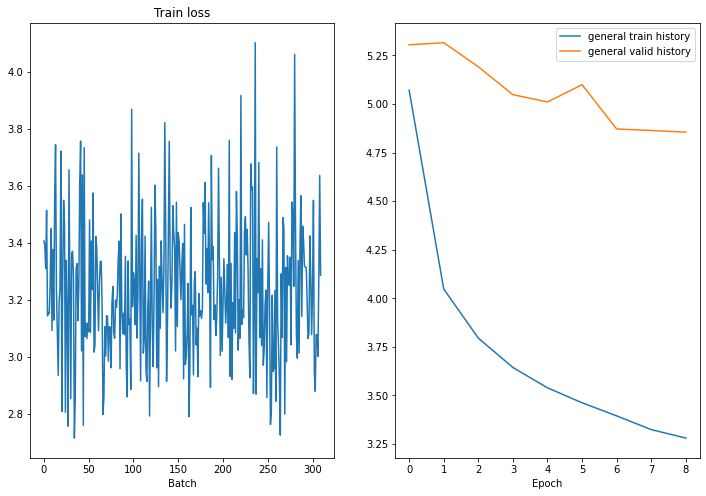

Epoch: 10 | Time: 1m 41s
	Train Loss: 3.234 | Train PPL:  25.379
	 Val. Loss: 4.957 |  Val. PPL: 142.191


In [ ]:
for epoch in range(10):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# if updated code is not loading, try using the `imp` module
# import utils
# import imp
# imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
trg.shape

torch.Size([86, 1])

In [ ]:
batch.trg.shape

torch.Size([86, 76])

In [ ]:
trg.shape

torch.Size([86, 1])

In [ ]:
for idx in [1]:
    src = batch.src
    trg = batch.trg
    generate_translation(src, trg, model, TRG.vocab)

Original: guests can visit spa at the , . the spa features 12 treatment rooms including a couple ’ s suite and vip suite , locker facilities with showers , sauna , herbal steam and whirlpool , a fitness center and full service salon . the luxurious spa offers signature treatments inspired by traditional chinese ( ), - edge care technology and boutique lines .
Generated: offering a restaurant , a restaurant , a restaurant , a restaurant and a restaurant .



In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].cpu().numpy().T])

59it [00:04, 12.13it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

10.4304633699032

### Эксперимент №4 (22.5%)
__Гипотеза:__ _ваша замечательная гипотеза_

In [ ]:
# your code, plots and comments here

___

### Выводы (10%):
Лучше всего оказались CNN, так как они не особо сложные в плане архитектуры, при этом довольно информативные и относительно быстро учатся, по сравнению с трансформером. Трансформер выдал самые плохие резултаты, скорее всего из-за отсутсвтия тюнинга гиперпараметров, в итоге он очень быстро переобучился и толком ничего не выучил. 

Аттеншон реализовать у меня не получлось, потому что опять начались расхождения с размерностями: не было полного понимания, что и в какой форме приходит на вход. Такая же проблема была и при реализации трансформера, много времени ушло, чтобы просто понять, что он хочет увидеть на вход, и что вообще вышло из енкодера. Именно фактические значения и размерность, а не в целом их смысл. 


Пожалуйста, оставьте обратную связь о задании [по ссылке](http://rebrand.ly/mfnlp2020q4_feedback_hw06). Она (при желании) анонимна ;)